In [40]:
import os

import corner
import matplotlib.pyplot as plt
import numpy as np

from starcluster.extract_data import EquatorialData

from corner import corner as crn
from figaro.mixture import DPGMM
from figaro.utils import get_priors
from pathlib import Path

n_alot = 10000

In [41]:
def dpgmm(path, outpath, std=None):
    dataset = EquatorialData(path=data_path, convert=True)
    dataset.save_dataset(outpath=outpath)
    
    for i, s in enumerate(dataset):
        for col in s.dtype.names:
            if np.isnan(s[col]) or np.isinf(s[col]):
                printt(i, s)

    l = dataset['l']
    b = dataset['b']
    plx = dataset['plx']
    pml = dataset['pml_star']
    pmb = dataset['pmb']
    v_rad = dataset['v_rad']
    g_mag = dataset['g_mag']
    bp_rp = dataset['bp_rp']

    bounds = [[l.min() - 1e-3, l.max() + 1e3],
              [b.min() - 1e-3, b.max() + 1e-3],
              [plx.min() - 1e-3, plx.max() + 1e-3],
              [pml.min() - 1e-3, pml.max() + 1e-3],
              [pmb.min() - 1e-3, pmb.max() + 1e-3],
              [v_rad.min() - 1e-3, v_rad.max() + 1e-3],
              [g_mag.min() - 1e-3, g_mag.max() + 1e-3],
              [bp_rp.min() - 1e-3, bp_rp.max() + 1e-3]]

    samples = dataset.as_array()
    
    if std is None:
        prior = get_priors(bounds, samples)
    else:
        prior = get_priors(bounds, std=std)

    mix = DPGMM(bounds=bounds,
                prior_pars=prior)

    density = mix.density_from_samples(samples)
    
    return dataset, bounds, prior, mix, density

In [42]:
def corner_plot(density, dataset, ra, dec, l, b, plx, pmra, pmdec, v_rad, g_mag, bp_rp, len_dataset, plot_title):
    density_samples = density.rvs(len_dataset)

    c = crn(density_samples,
            bins=int(np.sqrt(len_dataset)),
            color='dodgerblue',
            title=plot_title,
            labels=[r'$l\,[deg]$',
                    r'$b\,[deg]$',
                    r'$plx\,[mas]$',
                    r'$\mu_{l*}\,[mas\,yr^{-1}]$',
                    r'$\mu_b\,[mas\,yr^{-1}]$',
                    r'$v_{rad}\,[km\,s^{-1}]$',
                    r'$G\,[mag]$',
                    r'$G_{BP} - G_{RP}\,[mag]$'],
            hist_kwargs={'density': True,
                         'label': 'DPGMM'})

    c.suptitle(plot_title, size=20)

    ra_rad = np.deg2rad(ra)
    dec_rad = np.deg2rad(dec)
    l_rad = np.deg2rad(l)
    b_rad = np.deg2rad(b)

    p_icrs = np.array([-np.sin(ra_rad),
                       np.cos(ra_rad),
                       0])
    q_icrs = np.array([-np.cos(ra_rad) * np.sin(dec_rad),
                       -np.sin(ra_rad) * np.sin(dec_rad),
                       np.cos(dec_rad)])
    p_gal = np.array([-np.sin(l_rad),
                      np.cos(l_rad),
                      0])
    q_gal = np.array([-np.cos(l_rad) * np.sin(b_rad),
                      -np.sin(l_rad) * np.sin(b_rad),
                      np.cos(b_rad)])

    mu_icrs = p_icrs * pmra + q_icrs * pmdec
    mu_gal = dataset.A_G_inv.dot(mu_icrs)

    pml_star = np.dot(p_gal, mu_gal)
    pmb = np.dot(q_gal, mu_gal)

    data_lines = np.array([
        l, b, plx, pml_star, pmb, v_rad, g_mag, bp_rp
    ])

    corner.overplot_lines(c, data_lines,
                          color="C1",
                          linewidth=0.5,
                          label='data from SIMBAD')
    corner.overplot_points(c, data_lines[None],
                           marker=".",
                           color="C1")

    leg = plt.legend(loc=0, frameon=False, fontsize=15,
                     bbox_to_anchor=(1 - 0.05, 3))
    
    return c

## Pleiades

In [43]:
data_path = Path(os.getcwd()).joinpath('data/pleiades-kin+phot.csv')
outpath = Path(os.getcwd()).joinpath('data/pleiades.txt')

# data from SIMBAD - Pleiades
ra = 56.6010
dec = +24.1140
l = 166.4628
b = -23.6146
pmra = 19.997
pmdec = -45.548
v_rad = 6.57
plx = 7.364

plot_title = data_path.parts[-1]
plot_title = plot_title.strip('.csv')
plot_title = plot_title.strip('_gal')
plot_title = plot_title.strip('gaia')

In [74]:
std = np.array([0.5, .7, 0.5,
                dataset_pleiades['pml_star'].std(), dataset_pleiades['pmb'].std(), 5,
                2, 0.4])
std = None
dataset_pleiades, bounds_pleiades, prior_pleiades, mix_pleiades, density_pleiades = dpgmm(data_path, outpath,
                                                                                         std=std)

In [75]:
dataset_pleiades.as_array().shape

(1178, 8)

In [76]:
N_stars = dataset_pleiades.as_array().shape[0]

In [77]:
density_pleiades.n_cl

623

### Plot

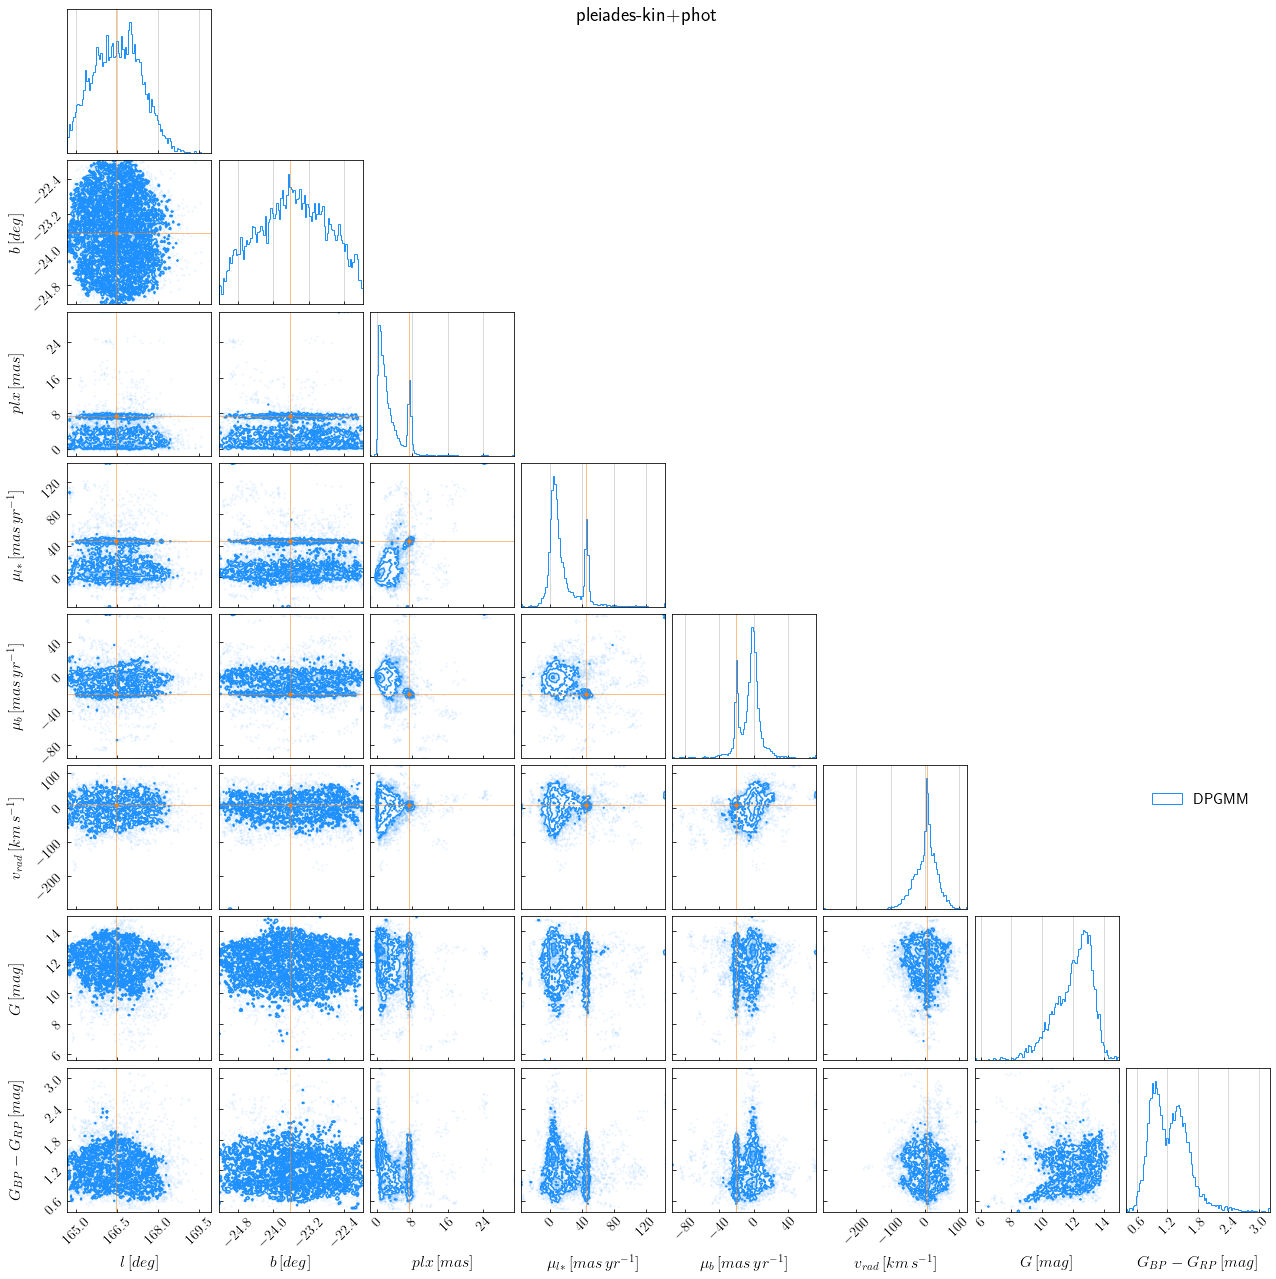

In [78]:
fig = corner_plot(density_pleiades, dataset_pleiades, ra, dec, l, b, plx, pmra, pmdec, v_rad, None, None, n_alot, plot_title)
plt.show()

In [9]:
fig.savefig(f'pleiades-kin+phot-{n_alot}.pdf', format='pdf')

## M4

In [23]:
data_path = Path(os.getcwd()).joinpath('data/M4-kin+phot.csv')
outpath = Path(os.getcwd()).joinpath('data/M4.txt')

# data from SIMBAD - M4
ra = 245.89675
dec = -26.52575
l = 350.97293
b = +15.97218
pmra = -12.48
pmdec = -18.99
v_rad = 71.05
plx = 0.556

plot_title = data_path.parts[-1]
plot_title = plot_title.strip('.csv')
plot_title = plot_title.strip('_gal')
plot_title = plot_title.strip('gaia')

In [24]:
dataset_m4, bounds_m4, prior_m4, mix_m4, density_m4 = dpgmm(data_path, outpath)

In [25]:
dataset_m4.as_array().shape

(269, 8)

In [26]:
N_stars = dataset_m4.as_array().shape[0]

In [27]:
density_m4.n_cl

84

### Plot

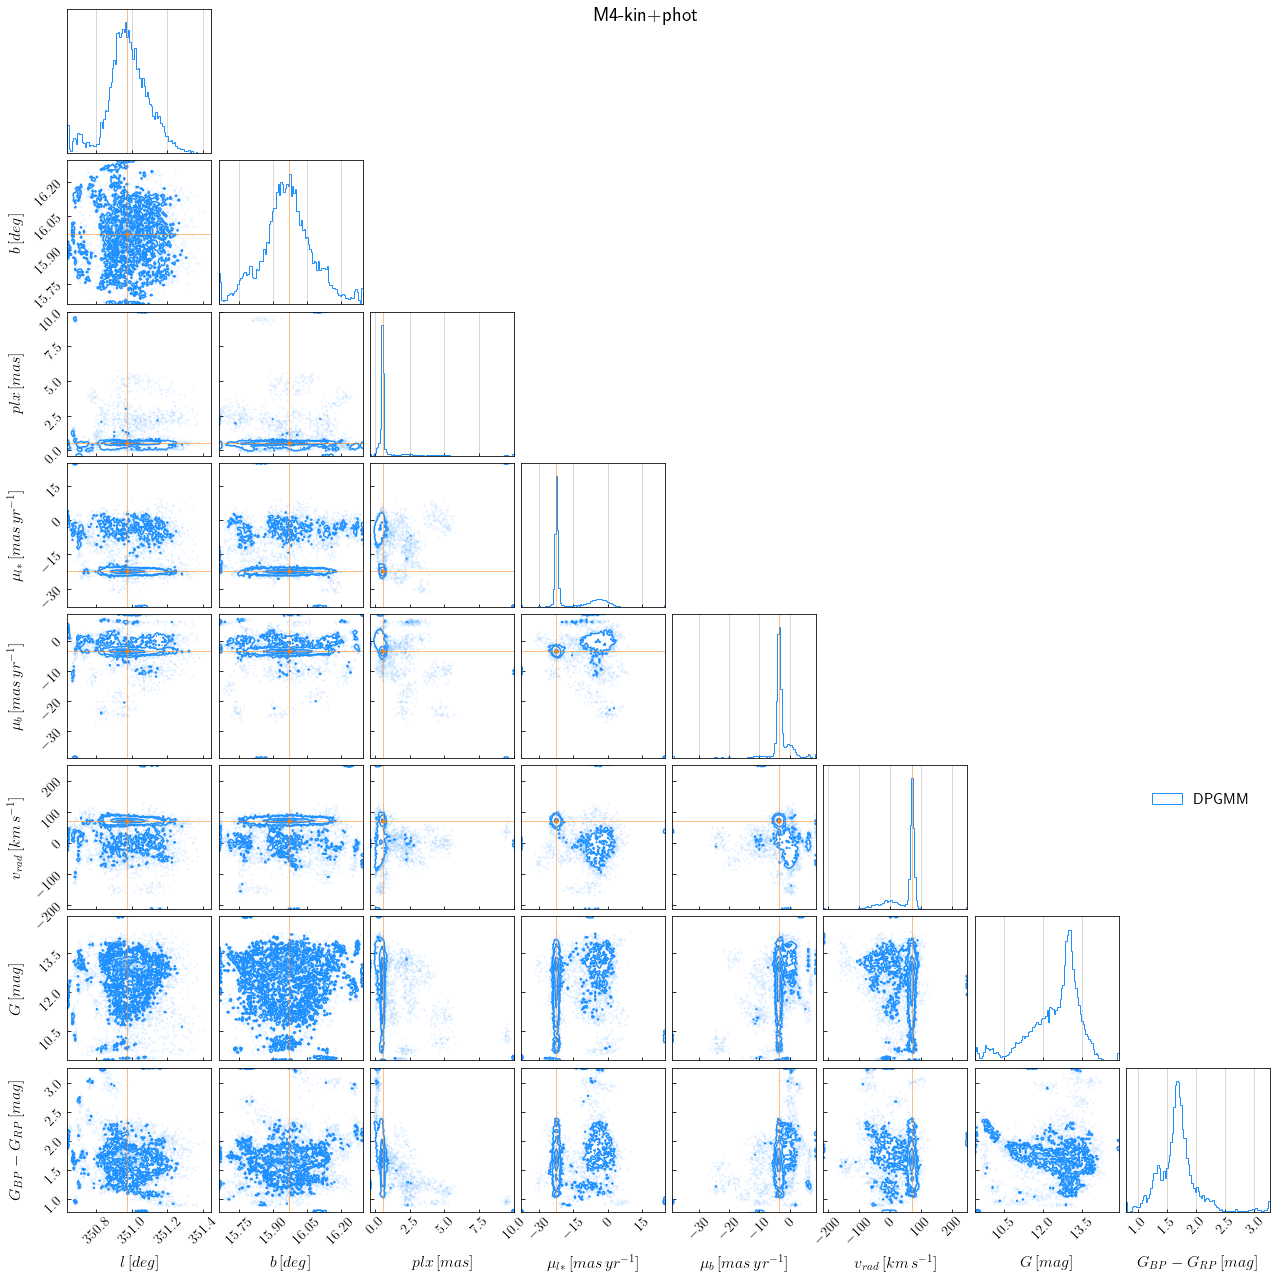

In [28]:
fig = corner_plot(density_m4, dataset_m4, ra, dec, l, b, plx, pmra, pmdec, v_rad, None, None, n_alot, plot_title)
plt.show()

In [29]:
fig.savefig(f'm4-kin+phot-{n_alot}.pdf', format='pdf')

## Omega Centauri

In [32]:
data_path = Path(os.getcwd()).joinpath('data/OmegaCen-kin+phot.csv')
outpath = Path(os.getcwd()).joinpath('data/OmegaCen.txt')

# data from SIMBAD - OmegaCen
ra = 201.69700
dec = -47.47947
l = 309.10202
b = +14.96833
pmra = -3.24
pmdec = -6.73
v_rad = 234.28
plx = 0.193

plot_title = data_path.parts[-1]
plot_title = plot_title.strip('.csv')
plot_title = plot_title.strip('_gal')
plot_title = plot_title.strip('gaia')

In [33]:
dataset_oc, bounds_oc, prior_oc, mix_oc, density_oc = dpgmm(data_path, outpath)

In [34]:
dataset_oc.as_array().shape

(521, 8)

In [35]:
N_stars = dataset_oc.as_array().shape[0]

### Plot

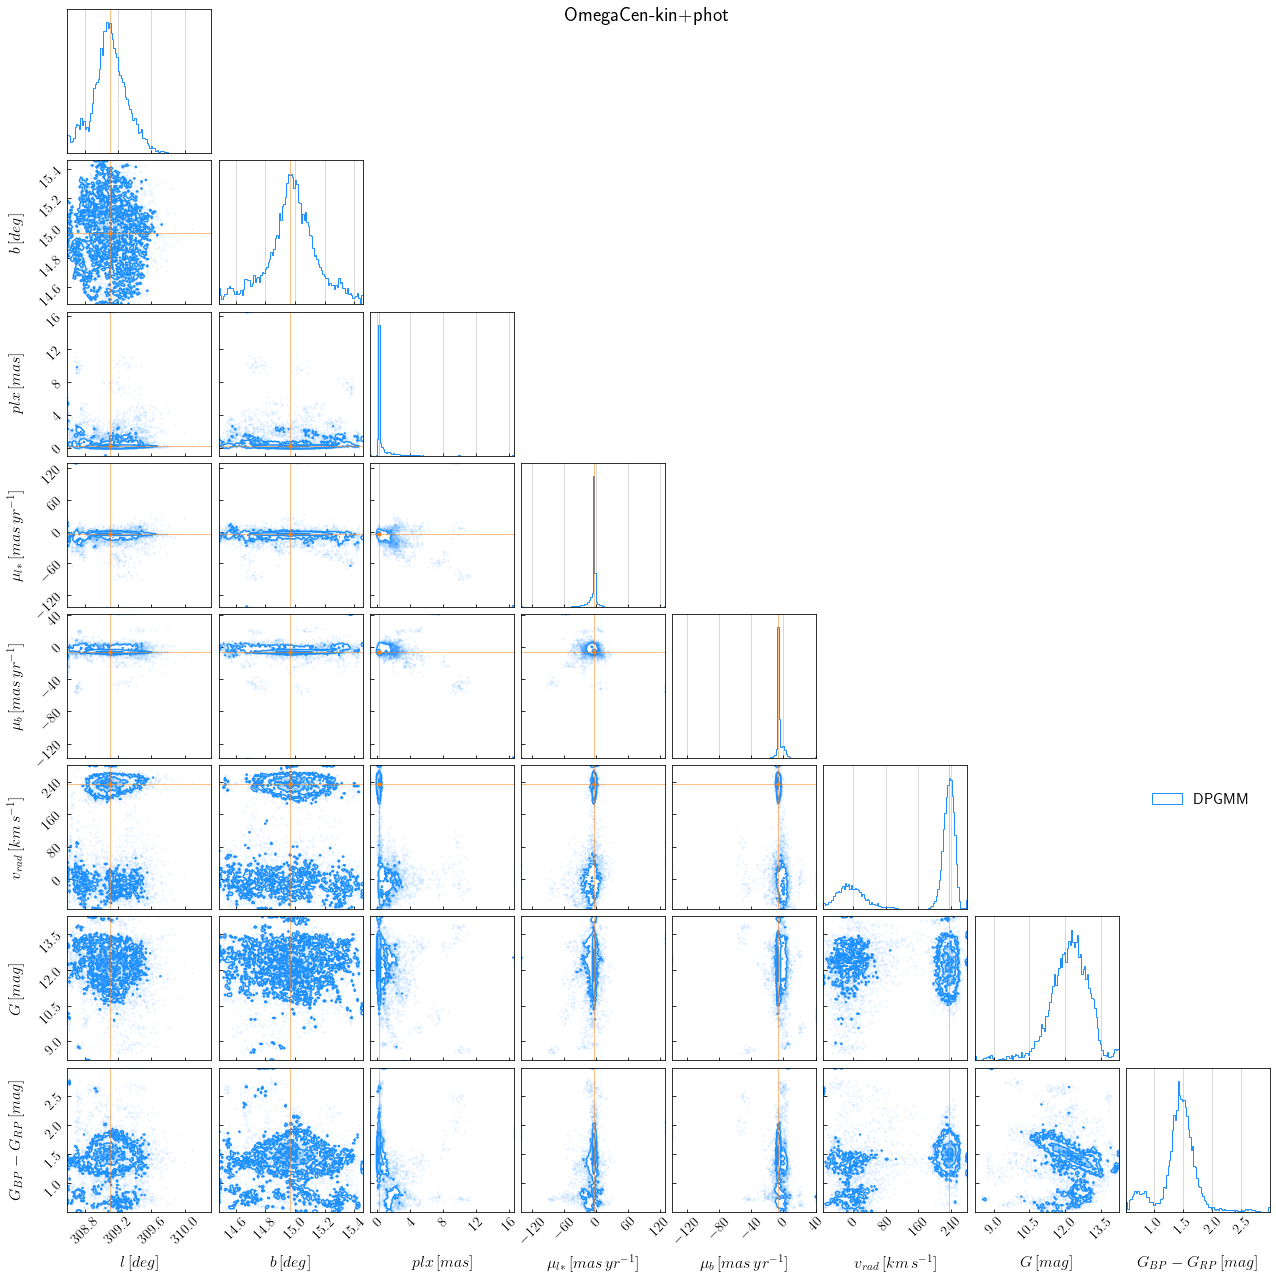

In [36]:
fig = corner_plot(density_oc, dataset_oc, ra, dec, l, b, plx, pmra, pmdec, v_rad, None, None, n_alot, plot_title)
plt.show()

In [37]:
fig.savefig(f'OmegaCen-kin+phot-{n_alot}.pdf', format='pdf')

In [38]:
## NGC2516

In [31]:
data_path = Path(os.getcwd()).joinpath('tests/test_data/gaiaNGC2516_gal.csv')
outpath = Path(os.getcwd()).joinpath('tests/NGC2516_gal.txt')

# data from SIMBAD
ra = 119.5270
dec = -60.8000
l = 273.8612
b = -15.8730
pmra = -4.6579
pmdec = 11.1517
v_rad = 24.2
plx = 2.4118

plot_title = data_path.parts[-1]
plot_title = plot_title.strip('.csv')
plot_title = plot_title.strip('_gal')
plot_title = plot_title.strip('gaia')

In [ ]:
dataset_ngc2516, bounds_ngc2516, prior_ngc2516, mix_ngc2516, density_ngc2516 = dpgmm(data_path, outpath)

In [ ]:
dataset_ngc2516.as_array().shape

In [ ]:
N_stars = dataset_ngc2516.as_array().shape[0]

In [ ]:
### Plot

In [ ]:
fig = corner_plot(density_ngc2516, dataset_ngc2516, ra, dec, l, b, pmra, pmdec, v_rad, plx, n_alot, plot_title)
plt.show()

In [ ]:
fig.savefig(f'ngc2516-{n_alot}.pdf', format='pdf')